In [1]:
import pandas as pd
import numpy as np
# load libraries  45.03423447058859 42.58356449833813

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import optuna

In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")
test_ground_truth=pd.read_csv("dataset/sdoh_test_labels.csv")

In [3]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

merged_df_keep = merged_df.copy()

final_test = pd.merge(test, test_ground_truth, on='uid', how='left')

In [4]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [5]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [6]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [7]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_processed = feature_engineering(data_processed)
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_2503720/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2503720/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2503720/2658724754.py:13: FutureWarning: Downcasting behavior i

n_mar_03 33.83 % missing
edu_gru_03 33.55 % missing
glob_hlth_03 36.99 % missing
n_adl_03 33.5 % missing
n_iadl_03 36.99 % missing
n_depr_03 37.1 % missing
n_illnesses_03 33.31 % missing
decis_personal_03 37.17 % missing
glob_hlth_12 5.8 % missing
n_iadl_12 5.84 % missing
n_depr_12 6.52 % missing
bmi_12 12.48 % missing
memory_12 6.72 % missing
rearnings_03 33.37 % missing
searnings_03 49.98 % missing
hincome_03 34.01 % missing
hinc_business_03 32.98 % missing
hinc_rent_03 32.98 % missing
hinc_assets_03 32.98 % missing
hinc_cap_03 32.98 % missing
rinc_pension_03 33.37 % missing
sinc_pension_03 49.98 % missing
searnings_12 35.19 % missing
sinc_pension_12 35.19 % missing
hincome_change 37.28 % missing
niadl_change 41.13 % missing
adl_change 36.4 % missing
depr_change 41.65 % missing
glob_hlth_change 41.1 % missing
edu_gru_change 36.09 % missing
illnesses_change 36.29 % missing


/tmp/ipykernel_2503720/3102208485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_2503720/3102208485.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [8]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_2503720/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2503720/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_2503720/2658724754.py:13: FutureWarning: Downcasting behavior i

In [9]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [10]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [11]:
best_params = {'lightgbm': {'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077},
 'RandomForest': {'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97},
 'XGBoost': {'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804},
 'CatBoost': {'depth': 6,
  'learning_rate': 0.025804617832891515,
  'l2_leaf_reg': 0.22567510948252656,
  'random_strength': 1.8064759944089426,
  'bagging_temperature': 0.4675254776654324,
  'iterations': 1224}}

In [12]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]
    
    train_X_processed, val_X_processed = merged_df_processed[keep_train], merged_df_processed[keep_val]
    train_X_processed.drop(columns=['uid'], inplace=True)
    val_X_processed.drop(columns=['uid'], inplace=True)

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')
        
    best_params['lightgbm']['objective'] = 'regression'
    best_params['lightgbm']['metric'] = 'rmse'
    best_params['lightgbm']['random_state'] = 42

    # Train the model with early stopping
    model1 = lgb.train(
        best_params['lightgbm'],
        train_data,
        valid_sets=[val_data],
        num_boost_round=best_params['lightgbm']['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        **best_params['CatBoost'],
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500,
        random_state=42
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(
        **best_params['XGBoost'],
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500,
        random_state=42)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/4, 1/4, 1/4, 1/4]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]

/tmp/ipykernel_2503720/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:22: Setti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

1it [00:13, 13.92s/it]

RandomForest rmse:  41.40240832073953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1873
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 193
[LightGBM] [Info] Start training from score 157.507613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2503720/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:22: Setti

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2it [00:28, 14.50s/it]

RandomForest rmse:  41.86014953346427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 3477, number of used features: 193
[LightGBM] [Info] Start training from score 158.134311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2503720/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:22: Setti

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

3it [00:45, 15.45s/it]

RandomForest rmse:  41.668332497610265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 193
[LightGBM] [Info] Start training from score 156.698043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/tmp/ipykernel_2503720/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:22: Setti

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

4it [01:02, 15.94s/it]

RandomForest rmse:  41.93586486784881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 3482, number of used features: 193
[LightGBM] [Info] Start training from score 157.416140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_2503720/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/61497616.py:22: Setti

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

5it [01:18, 15.76s/it]

RandomForest rmse:  41.0194548029115
Average MSE across folds: 40.157203856294316
Optimized weights per fold: [array([0.12145188, 0.37858822, 0.24972468, 0.25023522]), array([0.26212163, 0.38923649, 0.19818386, 0.15045803]), array([0.51988434, 0.11820941, 0.25047872, 0.11142753]), array([0.32586098, 0.46363518, 0.20992296, 0.00058088]), array([0.06997261, 0.57577691, 0.18605495, 0.16819553])]


In [13]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.157203856294316


In [14]:
np.mean(optimized_weights_list, axis=0)

array([0.25985829, 0.38508924, 0.21887303, 0.13617944])

In [15]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)
merged_df_processed.drop(columns=['uid'], inplace=True)
merged_test_processed.drop(columns=['uid'], inplace=True)
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

best_params['lightgbm']['objective'] = 'regression'
best_params['lightgbm']['metric'] = 'rmse'
best_params['lightgbm']['random_state'] = 42

final_model1 = lgb.train(
    best_params['lightgbm'],
    train_data,
    num_boost_round=best_params['lightgbm']['n_estimators']
)

final_model2 = CatBoostRegressor(
    **best_params['CatBoost'],
    loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    random_state=42
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(
    **best_params['XGBoost'],
    enable_categorical=True,
    eval_metric=root_mean_squared_error,
    random_state=42)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

final_test['predicted_composite_score']=final_test_predictions
final_test['predicted_composite_score_lgb']=test_pred1
final_test['predicted_composite_score_CatBoost']=test_pred2
final_test['predicted_composite_score_XGB']=test_pred3
final_test['predicted_composite_score_rf']=test_pred4

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2008
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 193
[LightGBM] [Info] Start training from score 157.016809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_2503720/3755832339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/3755832339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/3755832339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_2503720/37558323

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [16]:
final_test['predicted_composite_score']=final_test_predictions
final_test['predicted_composite_score_lgb']=test_pred1
final_test['predicted_composite_score_CatBoost']=test_pred2
final_test['predicted_composite_score_XGB']=test_pred3
final_test['predicted_composite_score_rf']=test_pred4

In [17]:
# mean squared error on test set
root_mean_squared_error(final_test['composite_score'], final_test['predicted_composite_score'])

39.23915534535873

### 1- Assess Bias in Gender Representation


In [18]:
final_test["ragender"] = final_test["ragender"].replace({"2.Woman": "Woman", "1.Man": "Man"})

Gender Distribution in Training Data:
ragender
2.Woman    0.581395
1.Man      0.418605
Name: proportion, dtype: float64
Target Variable Distribution by Gender:
           count        mean        std  min    25%    50%     75%    max
ragender                                                                 
1.Man     1818.0  159.512651  59.664584  4.0  117.0  159.0  201.75  325.0
2.Woman   2525.0  155.219802  61.739680  8.0  112.0  156.0  198.00  334.0


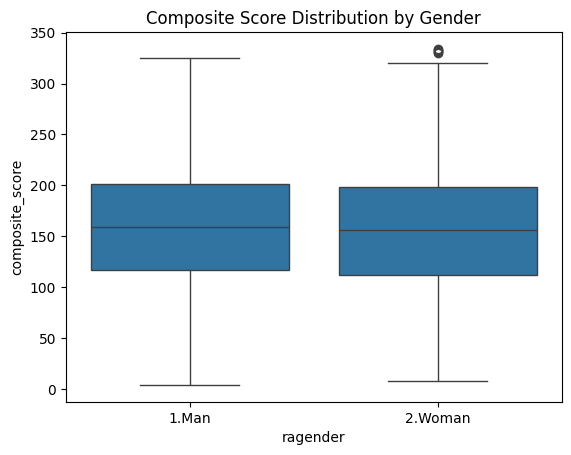

In [19]:
# in the training data

# Check gender distribution in the dataset
print("Gender Distribution in Training Data:")
print(merged_df_keep['ragender'].value_counts(normalize=True))

# Compare the target variable across genders
print("Target Variable Distribution by Gender:")
print(merged_df_keep.groupby('ragender')['composite_score'].describe())

# Visualize the differences
sns.boxplot(x='ragender', y='composite_score', data=merged_df_keep)
plt.title("Composite Score Distribution by Gender")
plt.show()


Gender Distribution in Test Data:
ragender
Woman    0.604525
Man      0.395475
Name: proportion, dtype: float64
Target Variable Distribution by Gender:
          count        mean        std   min    25%    50%    75%    max
ragender                                                                
Man       437.0  158.009153  61.724788  19.0  113.0  158.0  203.0  322.0
Woman     668.0  158.844311  64.350122   9.0  113.0  160.0  207.0  334.0


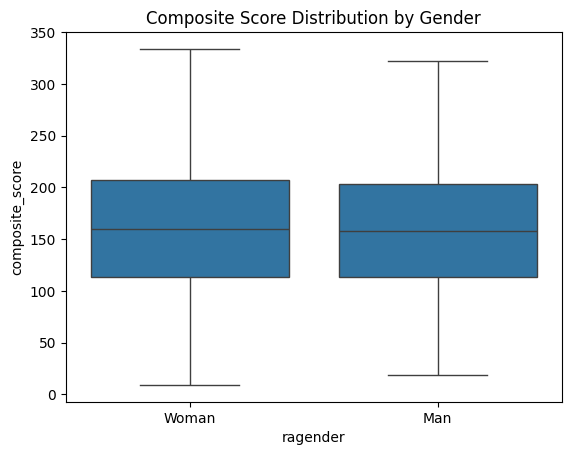

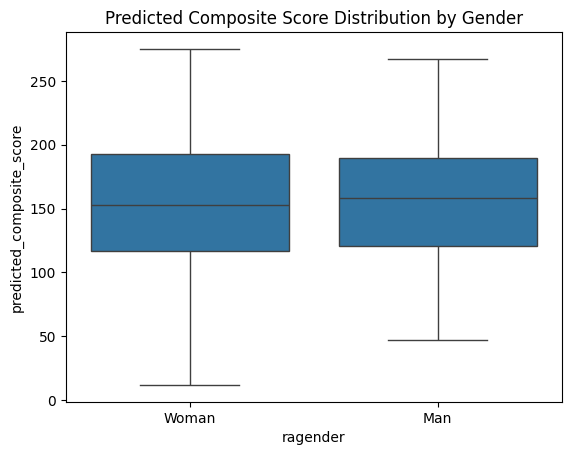

In [20]:
# in the test data

# Check gender distribution in the dataset
print("Gender Distribution in Test Data:")
print(final_test['ragender'].value_counts(normalize=True))

# Compare the target variable across genders
print("Target Variable Distribution by Gender:")
print(final_test.groupby('ragender')['composite_score'].describe())

# Visualize the differences
sns.boxplot(x='ragender', y='composite_score', data=final_test)
plt.title("Composite Score Distribution by Gender")
plt.show()

# Visualize the differences
sns.boxplot(x='ragender', y='predicted_composite_score', data=final_test)
plt.title("Predicted Composite Score Distribution by Gender")
plt.show()



### 2- Analyze Model Performance Across Gender Groups


In [21]:
# Evaluate RMSE across gender groups
def evaluate_gender_bias(composite_score, predicted_composite_score):
    gender_groups = ["Woman", "Man"]
    gender_rmse = {}
    for gender in gender_groups:
        gender_mask = final_test['ragender'] == gender
        group_rmse = root_mean_squared_error(composite_score[gender_mask], predicted_composite_score[gender_mask])
        gender_rmse[gender] = group_rmse
    return gender_rmse

gender_rmse = evaluate_gender_bias(final_test['composite_score'],final_test['predicted_composite_score'])
print("RMSE by Gender Group for combined models:")
print(gender_rmse)
print(gender_rmse['Man'] - gender_rmse['Woman'])

gender_rmse = evaluate_gender_bias(final_test['composite_score'],final_test['predicted_composite_score_lgb'])
print("RMSE by Gender Group for lgb:")
print(gender_rmse)
print(gender_rmse['Man'] - gender_rmse['Woman'])

gender_rmse = evaluate_gender_bias(final_test['composite_score'],final_test['predicted_composite_score_CatBoost'])
print("RMSE by Gender Group for CatBoost:")
print(gender_rmse)
print(gender_rmse['Man'] - gender_rmse['Woman'])

gender_rmse = evaluate_gender_bias(final_test['composite_score'],final_test['predicted_composite_score_XGB'])
print("RMSE by Gender Group for XGB:")
print(gender_rmse)
print(gender_rmse['Man'] - gender_rmse['Woman'])

gender_rmse = evaluate_gender_bias(final_test['composite_score'],final_test['predicted_composite_score_rf'])
print("RMSE by Gender Group for rf:")
print(gender_rmse)
print(gender_rmse['Man'] - gender_rmse['Woman'])


RMSE by Gender Group for combined models:
{'Woman': 38.126758327961774, 'Man': 40.88111356389716}
2.7543552359353853
RMSE by Gender Group for lgb:
{'Woman': 40.48389202011546, 'Man': 42.7849540365578}
2.301062016442337
RMSE by Gender Group for CatBoost:
{'Woman': 37.763397200828514, 'Man': 41.158865268449084}
3.3954680676205697
RMSE by Gender Group for XGB:
{'Woman': 39.25571347865169, 'Man': 41.53126651764561}
2.2755530389939196
RMSE by Gender Group for rf:
{'Woman': 40.69814383275644, 'Man': 43.118320136599806}
2.4201763038433626


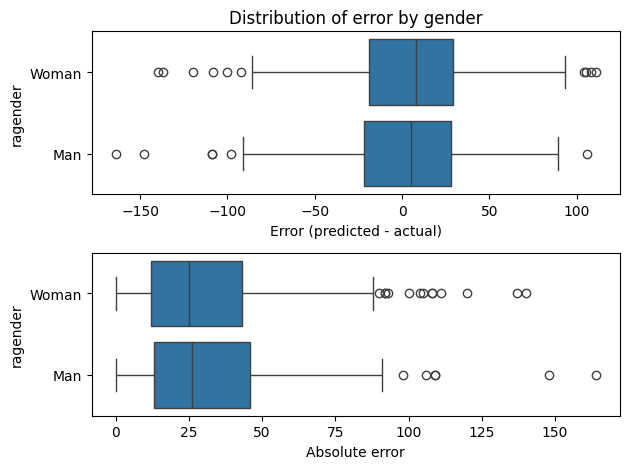

In [23]:
# get absolute error for each prediction
final_test["abs_error"] = np.abs(final_test.composite_score - final_test.predicted_composite_score)
final_test["squared_error"] = (final_test.composite_score - final_test.predicted_composite_score) ** 2
final_test["error"] = final_test.composite_score - final_test.predicted_composite_score

# Compare the distribution of error for men vs. women
_, axes = plt.subplots(2, 1, sharey=True)
sns.boxplot(x=final_test.error, y=final_test.ragender, ax=axes[0])
axes[0].set_xlabel("Error (predicted - actual)")
axes[0].set_title("Distribution of error by gender")

sns.boxplot(x=final_test.abs_error, y=final_test.ragender, ax=axes[1])
axes[1].set_xlabel("Absolute error")
plt.tight_layout()

### 3- Counterfactual Fairness Check

In [24]:
merged_test["ragender"]

4343    2.Woman
4344    2.Woman
4345    2.Woman
4346      1.Man
4347      1.Man
         ...   
5443    2.Woman
5444    2.Woman
5445    2.Woman
5446    2.Woman
5447      1.Man
Name: ragender, Length: 1105, dtype: category
Categories (2, object): ['1.Man', '2.Woman']

In [25]:
merged_test_processed['ragender_2.Woman']

4343    1.0
4344    1.0
4345    1.0
4346    0.0
4347    0.0
       ... 
5443    1.0
5444    1.0
5445    1.0
5446    1.0
5447    0.0
Name: ragender_2.Woman, Length: 1105, dtype: float64

In [38]:
# Counterfactual fairness analysis
def counterfactual_analysis(original_gender, new_gender):
    merged_test_original = merged_test[merged_test['ragender'] == original_gender]
    merged_test_counterfactual = merged_test_original.copy()
    merged_test_counterfactual['ragender'] = new_gender
    categories = ['1.Man', '2.Woman']
    merged_test_counterfactual['ragender'] = merged_test_counterfactual['ragender'].astype(
    pd.CategoricalDtype(categories=categories))
    
    if original_gender == "2.Woman":
        gender = 1.0
        chanded = 0.0
    else:
        gender = 0.0
        chanded = 1.0
    merged_test_processed_original = merged_test_processed[merged_test_processed['ragender_2.Woman'] == gender]
    merged_test_processed_counterfactual = merged_test_processed_original.copy()
    merged_test_processed_counterfactual['ragender_2.Woman'] = chanded
    
    
    
    test_pred1 = final_model1.predict(merged_test_original)
    test_pred2 = final_model2.predict(merged_test_original)
    test_pred3 = final_model3.predict(merged_test_original)
    test_pred4 = final_model4.predict(merged_test_processed_original)
    
    # Combine the predictions using the average weights
    final_test_predictions = (
        average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
    )
    
    counterfactual_test_pred1 = final_model1.predict(merged_test_counterfactual)
    counterfactual_test_pred2 = final_model2.predict(merged_test_counterfactual)
    counterfactual_test_pred3 = final_model3.predict(merged_test_counterfactual)
    counterfactual_test_pred4 = final_model4.predict(merged_test_processed_counterfactual)
    
    # Combine the predictions using the average weights
    counterfactual_final_test_predictions = (
        average_weights[0] * counterfactual_test_pred1 + average_weights[1] * counterfactual_test_pred2 + average_weights[2] * counterfactual_test_pred3 + average_weights[3] * counterfactual_test_pred4
    )
    
    differences_final = counterfactual_final_test_predictions - final_test_predictions
    differences_lgb = counterfactual_test_pred1 - test_pred1
    differences_CatBoost = counterfactual_test_pred2 - test_pred2
    differences_XGB = counterfactual_test_pred3 - test_pred3
    differences_rd = counterfactual_test_pred4 - test_pred4
    
    
    return np.mean(np.abs(differences_final)), np.mean(np.abs(differences_lgb)), np.mean(np.abs(differences_CatBoost)), np.mean(np.abs(differences_XGB)), np.mean(np.abs(differences_rd))

original_gender = '1.Man'
new_gender = '2.Woman'
counterfactual_bias_final, counterfactual_bias_lgb, counterfactual_bias_CatBoost,\
    counterfactual_bias_XGB, counterfactual_bias_rd = counterfactual_analysis(original_gender, new_gender)
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_final} for final model")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_lgb} for lgb")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_CatBoost} for CatBoost")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_XGB} for XGB")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_rd} for rf")

original_gender = '2.Woman'
new_gender = '1.Man'
counterfactual_bias_final, counterfactual_bias_lgb, counterfactual_bias_CatBoost,\
    counterfactual_bias_XGB, counterfactual_bias_rd = counterfactual_analysis(original_gender, new_gender)
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_final} for final model")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_lgb} for lgb")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_CatBoost} for CatBoost")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_XGB} for XGB")
print(f"Average Prediction Change from '{original_gender}' to '{new_gender}': {counterfactual_bias_rd} for rf")


Average Prediction Change from '1.Man' to '2.Woman': 0.20407499792119554 for final model
Average Prediction Change from '1.Man' to '2.Woman': 0.6549455895608475 for lgb
Average Prediction Change from '1.Man' to '2.Woman': 0.11547615638146673 for CatBoost
Average Prediction Change from '1.Man' to '2.Woman': 0.1663322001695633 for XGB
Average Prediction Change from '1.Man' to '2.Woman': 0.20056652716685355 for rf
Average Prediction Change from '2.Woman' to '1.Man': 0.2247721241638466 for final model
Average Prediction Change from '2.Woman' to '1.Man': 0.6843641234311474 for lgb
Average Prediction Change from '2.Woman' to '1.Man': 0.12967478486911618 for CatBoost
Average Prediction Change from '2.Woman' to '1.Man': 0.15129615366458893 for XGB
Average Prediction Change from '2.Woman' to '1.Man': 0.1807335819367 for rf


### 4. Add binary predictions

In [39]:
final_test["ragender"] = final_test["ragender"].replace({"2.Woman": "Woman", "1.Man": "Man"})

In [43]:
#low_threshold = y.mean() - 1 * y.std()
low_threshold = y.quantile(0.25)  # Bottom 25%
final_test["actual_atrisk"] = final_test['composite_score'] <= low_threshold
final_test["pred_atrisk"] = final_test['predicted_composite_score'] <= low_threshold

print(f"{final_test.actual_atrisk.mean():.1%} of people are actually high risk")
print(f"{final_test.pred_atrisk.mean():.1%} of people are predicted to be high risk")

25.7% of people are actually high risk
22.9% of people are predicted to be high risk


In [44]:
pd.crosstab(final_test.actual_atrisk, final_test.pred_atrisk, margins=True)

pred_atrisk,False,True,All
actual_atrisk,,,
False,734,87,821
True,118,166,284
All,852,253,1105


### Equal opportunity

In [45]:
# get the true positive rate for each gender
(
    true_positive_rates := final_test.groupby("ragender")
    .apply(lambda x: x[x.actual_atrisk].pred_atrisk.mean(), include_groups=False)
    .to_frame(name="true_positive_rate")
)

,true_positive_rate
ragender,
Man,0.522523
Woman,0.624277


In [46]:
tpr_women = true_positive_rates.loc["Woman"].true_positive_rate
tpr_men = true_positive_rates.loc["Man"].true_positive_rate
print(
    f"Equal opportunity difference: {tpr_women:.1%} - {tpr_men:.1%} = {tpr_women - tpr_men:.1%}"
)

Equal opportunity difference: 62.4% - 52.3% = 10.2%


In [47]:
# get the true positive rate by urban/rural
(
    final_test.groupby("urban_12")
    .apply(lambda x: x[x.actual_atrisk].pred_atrisk.mean(), include_groups=False)
    .to_frame(name="true_positive_rate")
)

,true_positive_rate
urban_12,
"0. <100,000",0.656442
"1. 100,000+",0.490566


### Equalized odds

In [48]:
(
    false_positive_rates := final_test.groupby("ragender")
    .apply(lambda x: x[~x.actual_atrisk].pred_atrisk.mean(), include_groups=False)
    .to_frame(name="false_positive_rate")
)

,false_positive_rate
ragender,
Man,0.098160
Woman,0.111111


In [49]:
# Also look at the equalized odds difference
fpr_women = false_positive_rates.loc["Woman"].false_positive_rate
fpr_men = false_positive_rates.loc["Man"].false_positive_rate
print(f"False positive rate different: {fpr_women - fpr_men:.1%}")

False positive rate different: 1.3%


In [50]:
(
    final_test.groupby("urban_12")
    .apply(lambda x: x[~x.actual_atrisk].pred_atrisk.mean(), include_groups=False)
    .to_frame(name="false_positive_rate")
)

,false_positive_rate
urban_12,
"0. <100,000",0.220339
"1. 100,000+",0.041176


### Demographic parity

In [51]:
merged_df["ragender"] = merged_df["ragender"].replace({"2.Woman": "Woman", "1.Man": "Man"})

/tmp/ipykernel_2503720/1142850701.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  merged_df["ragender"] = merged_df["ragender"].replace({"2.Woman": "Woman", "1.Man": "Man"})
/tmp/ipykernel_2503720/1142850701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["ragender"] = merged_df["ragender"].replace({"2.Woman": "Woman", "1.Man": "Man"})


Text(0.5, 1.0, 'Composite score distribution by gender')

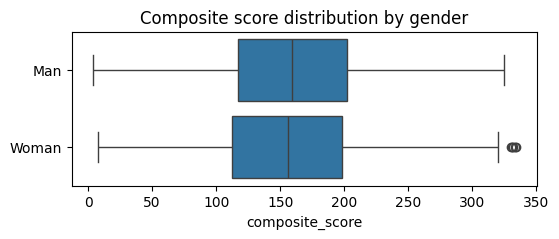

In [52]:
# on the training set
_, ax = plt.subplots(figsize=(6, 2))
sns.boxplot(
    x=y,
    y=merged_df["ragender"],
    ax=ax,
)
plt.ylabel("")
plt.title("Composite score distribution by gender")

Text(0.5, 1.0, 'Composite score distribution by gender')

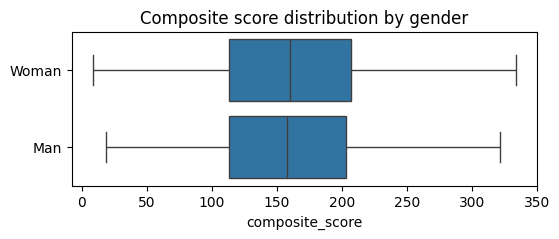

In [53]:
# on the test set
_, ax = plt.subplots(figsize=(6, 2))
sns.boxplot(
    x=final_test["composite_score"],
    y=final_test["ragender"],
    ax=ax,
)
plt.ylabel("")
plt.title("Composite score distribution by gender")

In [54]:
final_test.groupby("ragender").pred_atrisk.mean().to_frame(name="percent_positive_predictions")

,percent_positive_predictions
ragender,
Man,0.205950
Woman,0.244012
